In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import wine_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from sklearn.metrics import mean_squared_error

In [4]:
import time

In [5]:
X_train, X_test, y_train, y_test = wine_prep()

In [6]:
layers = 4
neurons = [32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 200
epochs = 20
optimizer = "adam"

Epoch 1/20
21/21 [==============================] - 0s 6ms/step - loss: 18.9758 - mse: 18.9758 - val_loss: 14.5454 - val_mse: 14.5454
Epoch 2/20
21/21 [==============================] - 0s 1ms/step - loss: 11.2927 - mse: 11.2927 - val_loss: 7.3980 - val_mse: 7.3980
Epoch 3/20
21/21 [==============================] - 0s 1ms/step - loss: 4.6709 - mse: 4.6709 - val_loss: 2.4696 - val_mse: 2.4696
Epoch 4/20
21/21 [==============================] - 0s 1ms/step - loss: 2.2588 - mse: 2.2588 - val_loss: 1.7300 - val_mse: 1.7300
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 1.7182 - mse: 1.7182 - val_loss: 1.4156 - val_mse: 1.4156
Epoch 6/20
21/21 [==============================] - 0s 1ms/step - loss: 1.4994 - mse: 1.4994 - val_loss: 1.2663 - val_mse: 1.2663
Epoch 7/20
21/21 [==============================] - 0s 1ms/step - loss: 1.3684 - mse: 1.3684 - val_loss: 1.1590 - val_mse: 1.1590
Epoch 8/20
21/21 [==============================] - 0s 2ms/step - loss: 1.2550 - mse

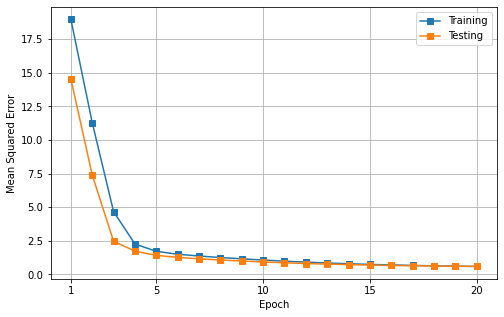

In [7]:
model = nn_model_structure(layers = layers,
                           neurons = neurons,
                           n_cols = n_cols,
                           classification = False)
model = nn_model_compile(model,
                         optimizer = optimizer)
start_time = time.time()
model = nn_model_fit(model,
                     X_train,
                     y_train,
                     X_val = X_test,
                     y_val = y_test,
                     batch_size = batch_size,
                     epochs = epochs)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_mse(model,
            mse_mean = None,
            start_epoch = 1,
            savefig = False,
            file = "../img/wine/wine_{}_E{}_B{}.png".format(optimizer, epochs, batch_size))
nn_save(model,
        "../models/wine/wine_{}_E{}_B{}.h5".format(optimizer, epochs, batch_size))

In [8]:
model_1 = nn_load("../models/wine/wine_sgd_E20_B200.h5")

In [9]:
enkf_model = nn_load("../models/wine/enkf_wine_full_E20_B200_P200_H2.h5")

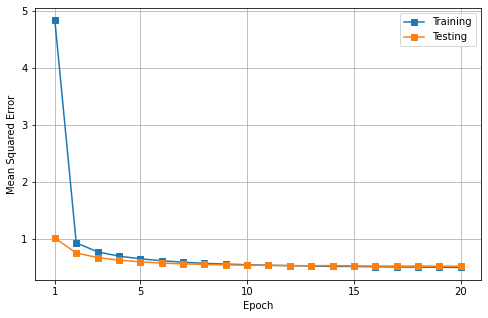

In [10]:
nn_plot_mse(model_1,
            mse_mean = None, # mean_squared_error(y_train, np.ones(shape = (len(y_train),))*np.mean(y_train))
            start_epoch = 1,
            title = "",
            savefig = False,
            file = "../img/accuracy_per_epoch.png"
            ) 

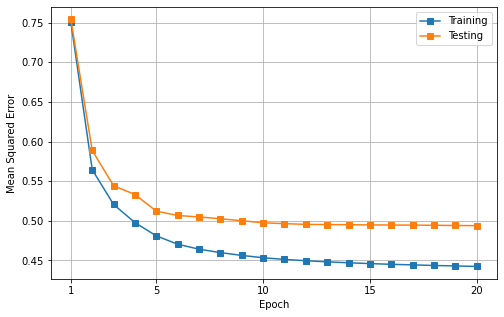

In [11]:
nn_plot_mse(enkf_model,
            mse_mean = None, # mean_squared_error(y_train, np.ones(shape = (len(y_train),))*np.mean(y_train))
            start_epoch = 1,
            title = "",
            savefig = False,
            file = "../img/accuracy_per_epoch.png"
            ) 

In [12]:
model_list = [model,
              model_1,
              enkf_model]
label_list = ["Adam",
              "SGD",
              "EnKF"]

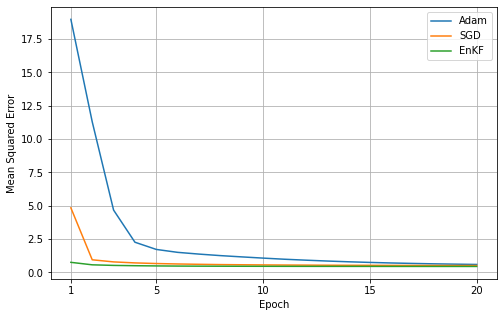

In [13]:
nn_plot_mse_many(model_list,
                 label_list,
                 train_test = "train",
                 mse_mean = None,
                 start_epoch = 1,
                 savefig = False,
                 file = "../img/wine/wine_{}_E{}_B{}.png".format(optimizer, epochs, batch_size))